In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('../../datasets/vazao/10-06-2023/tratado/cubic/tratado cubic esmond data pa-ba 06-10-2023.csv').copy()

#### Formatando o dataset de forma que as linhas agora são as semanas e as colunas os intervalos dos sete dias: análise de vazão considerando as características semanais 

In [20]:
new_df = pd.DataFrame()

for dia in range(1, 8):

    new_df["Dia " + str(dia) + " 00:00:00 à 05:59:59"] = -1
    new_df["Dia " + str(dia) + " 06:00:00 à 11:59:59"] = -1
    new_df["Dia " + str(dia) + " 12:00:00 à 17:59:59"] = -1
    new_df["Dia " + str(dia) + " 18:00:00 à 23:59:59"] = -1

comeco_vazao = 0
for i in range (0, int(len(df)/28)):
    dados_selecionados = df.loc[comeco_vazao:(comeco_vazao+27), "Vazao"].values
    new_df.loc["Semana " + str(i + 1)] = dados_selecionados
    comeco_vazao = comeco_vazao + 28

ultima = int(len(df)/28)

#caso o dataset não seja divisível por 28 (não preencha as colunas certinho)
if (len(df) % 28 != 0):
    dados_selecionados = df.loc[int(len(df)/28)*28: len(df), "Vazao"].values
    dados_selecionados = np.concatenate((dados_selecionados, -1 * np.ones(28 - len(dados_selecionados))))
    new_df.loc["Semana " + str(ultima + 1)] = dados_selecionados
    ultima = ultima + 1

#### Preenchendo os dados faltantes  (-1) com a média do valor daquele intervalo na semana anterior, posterior e o intervalo anterior e posterior (sem pesos)

In [21]:
def calcular_media_quadridimencional(df, old_df):
    
    contador_linha = 0
    for y in range(len(df)):
        for x in range(len(df.columns)):
            contador_linha = contador_linha + 1
            value = df.iloc[y, x]
            if (value == -1):
                novo_valor = 0
                contador = 0
                if(y != 0 and df.iloc[y-1, x] != -1):
                    valor_acima = df.iloc[y-1, x]
                    novo_valor += valor_acima
                    contador += 1
                if(y != len(df)-1 and df.iloc[y+1, x] != -1):
                    valor_abaixo = df.iloc[y+1, x]
                    novo_valor += valor_abaixo
                    contador += 1
                if(x != 1 and df.iloc[y, x-1] != -1):
                    valor_esquerdo = df.iloc[y, x-1]
                    novo_valor += valor_esquerdo
                    contador += 1
                    #return novo_valor
                if(x != len(df.columns)-1 and df.iloc[y, x+1] != -1):
                    valor_direito = df.iloc[y, x+1]
                    novo_valor += valor_direito
                    contador += 1
                if (contador != 0):
                    novo_valor = (novo_valor / contador)
                df.iloc[y, x] = novo_valor
            if (contador_linha == len(old_df)):
                break
            # col_name = df.columns[x]  
            # print(f'Índice da coluna (x): {x}, Índice da linha (y): {y}, Valor: {value}, Nome da coluna: {col_name}')
    

# Formatando a visualização para não ficar em notação científica
pd.options.display.float_format = '{:.1f}'.format
calcular_media_quadridimencional(new_df, df)

#### Retornando o dataset para o formato original (data por vazão)

In [22]:
back_df = df.copy()

linha = []
for i in range (1, ultima + 1):
   linha = np.concatenate([linha, new_df.loc["Semana " + str(i)].values])

# Verificando se fiz o preenchimento para completar todas as colunas
#Se der erro de conflito de tamanho, comentar ou descomentar as duas próximas linhas
#tam = len(linha) - len(df) 
# linha = linha[:-tam]
back_df["Vazao"] = linha

back_df.to_csv('../preenchido cubic esmond data pa-ba 06-10-2023.csv')


#### Verificando se o dataset tá igualzinho

In [23]:
result_df = df.copy()

# Compare as duas colunas e crie uma terceira coluna
result_df['Verificação'] = (df['Vazao'] == back_df['Vazao']) & (df['Vazao'] != -1) & (back_df['Vazao'] != -1)

# Substitua os valores True por False onde queremos -1
result_df['Verificação'] = result_df['Verificação'].replace({True: -1, False: True})

result_df    
#mjksnjkdsnakj

,Data,Intervalo,Vazao,Verificação
0,12-12-2022,00:00:00 a 06:00:00,-1.0,True
1,12-12-2022,06:00:00 a 12:00:00,-1.0,True
2,12-12-2022,12:00:00 a 18:00:00,913522060.0,-1
3,12-12-2022,18:00:00 a 23:59:59,484181435.5,-1
4,13-12-2022,00:00:00 a 06:00:00,924689149.0,-1
...,...,...,...,...
695,9-6-2023,18:00:00 a 23:59:59,670935882.0,-1
696,10-6-2023,00:00:00 a 06:00:00,891871177.0,-1
697,10-6-2023,06:00:00 a 12:00:00,37014830.0,-1
698,10-6-2023,12:00:00 a 18:00:00,-1.0,True


#### Plotagem dos gráficos

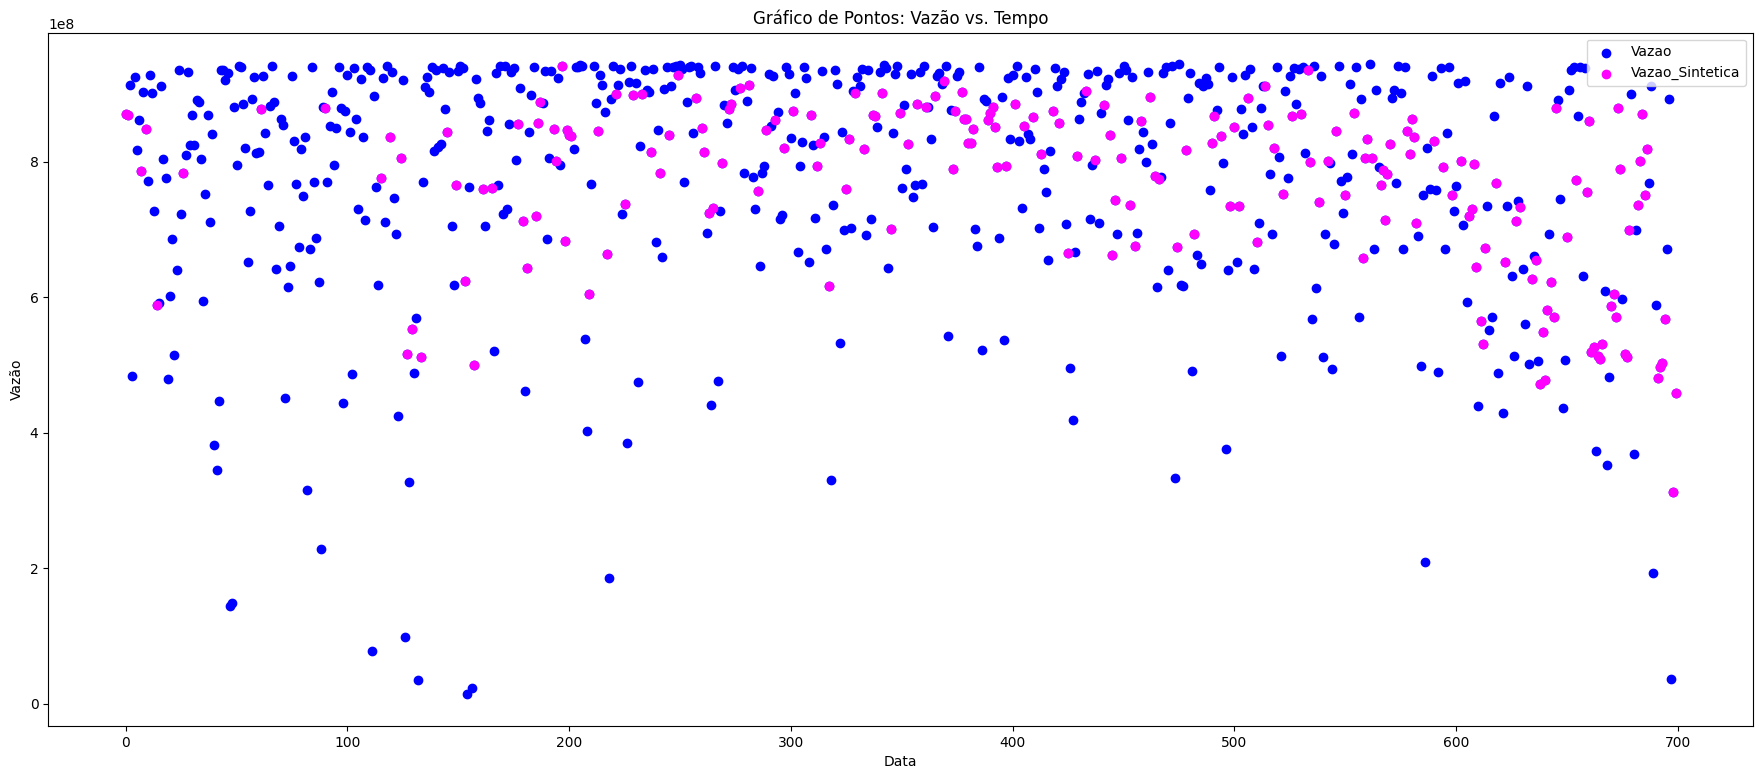

In [24]:
def plot_vazao(df):
    valid_vazao = df[df['Vazao'] != -1]['Vazao']
    plt.scatter(valid_vazao.index, valid_vazao, color='blue', label='Vazao')

def plot_vazao_sintetica(df):
    df['Vazao_Sintetica'] = np.where(df['Sintético'] == '1', df['Vazao'], np.nan)
    valid_vazao_sintetica = df[df['Vazao_Sintetica'].notnull()]['Vazao_Sintetica']
    plt.scatter(valid_vazao_sintetica.index, valid_vazao_sintetica, color='magenta', label='Vazao_Sintetica')

def plot_grafico(df):
    plt.figure(figsize=(22, 9))
    plot_vazao(df)
    plot_vazao_sintetica(df)
    plt.xlabel('Data')
    plt.ylabel('Vazão')
    plt.title('Gráfico de Pontos: Vazão vs. Tempo')
    plt.legend()
    plt.show()

# Criando uma coluna para dizer se os dados foram imputados, para plotar com cor diferente 
back_df['Sintético'] = np.where(df['Vazao'] == -1, '1', '0')
plot_grafico(back_df)